# Imports

In [1]:
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/data/"

LABELED_PATH = BASE_PATH + "labels_phase2.parquet"
XGB_MODEL_PATH = BASE_PATH + "XGB_predictions_loc_phase2.parquet"
RIDGE_MODEL_PATH = BASE_PATH + "Ridge_predictions_loc_phase2.parquet"
RF_RIDGE_MODEL_PATH = BASE_PATH + "RF_ridge_predictions_loc_phase2.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'


MODEL_LIST = ['BASELINE_LAST_WEEK', 'RIDGE_MODEL', 'XGB_MODEL', 'RF_RIDGE_MODEL']
CATEGORIES = ['high_demand_locations', 'low_demand_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['Location', 'Date', 'Hour_interval', 'Day_of_week']


TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'


NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 50
NUM_LOC = 262
SORT_METHOD = 'mean'



warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(251520, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-01-01,0,0.0
1,1,2023-01-01,3,1.0
2,1,2023-01-01,6,1.0
3,1,2023-01-01,9,1.0
4,1,2023-01-01,12,13.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
print(test_df.shape)
test_df.head()

(62880, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-04-01,0,0.0
1,1,2023-04-01,3,1.0
2,1,2023-04-01,6,1.0
3,1,2023-04-01,9,0.0
4,1,2023-04-01,12,1.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of RIDGE_MODEL (9000, 4)


,Location,Date,Hour_interval,Predicted_demand
0,13,2023-04-01,0,12.523696
1,13,2023-04-02,0,9.319751
2,13,2023-04-03,0,5.740769
3,13,2023-04-04,0,6.183158
4,13,2023-04-05,0,5.854326


shape of XGB_MODEL (12000, 4)


,Location,Date,Hour_interval,Predicted_demand
0,13,2023-04-01,0,6.882645
1,13,2023-04-01,3,3.907598
2,13,2023-04-01,6,18.509113
3,13,2023-04-01,9,84.011574
4,13,2023-04-01,12,131.182281


shape of RF_RIDGE_MODEL (12000, 4)


,Location,Date,Hour_interval,Predicted_demand
0,13,2023-04-01,0,8.442780
1,13,2023-04-01,3,4.163481
2,13,2023-04-01,6,19.832958
3,13,2023-04-01,9,86.338058
4,13,2023-04-01,12,134.741182


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['Location', 'Date', 'Hour_interval']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7*NUM_INTERVAL_PER_DAY)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(62880, 4)


,Location,Date,Hour_interval,Predicted_demand
56,1,2023-04-01,0,0.0
57,1,2023-04-01,3,0.0
58,1,2023-04-01,6,3.0
59,1,2023-04-01,9,2.0
60,1,2023-04-01,12,3.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['Location', 'Date', 'Hour_interval'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.0,5
1,1,2023-04-01,3,1.0,0.0,5
2,1,2023-04-01,6,1.0,3.0,5
3,1,2023-04-01,9,0.0,2.0,5
4,1,2023-04-01,12,1.0,3.0,5


shape of predictions_dict[RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


shape of predictions_dict[XGB_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        category_index = predictions_df.groupby(['Location'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD,ascending=False).reset_index()
        category_df = predictions_df.merge(category_index[:HIGH_DEMAND_NUMS], how='right', on=['Location'])
        category_min_df = category_df.groupby(['Location','Hour_interval']).agg(Min=('Demand','min')).sort_values(by='Min',ascending=False).reset_index()
        low_index=category_min_df[category_min_df['Min'].isin([0])]
        high_index=category_min_df[~category_min_df['Min'].isin([0])]
        sorted_locations_dict['high_demand_locations']=category_df.merge(high_index[['Location','Hour_interval']], on=['Location','Hour_interval'])[['Location','Hour_interval',SORT_METHOD]]
        sorted_locations_dict['low_demand_locations']=category_df.merge(low_index[['Location','Hour_interval']], on=['Location','Hour_interval'])[['Location','Hour_interval',SORT_METHOD]]

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_locations]: (11820, 3)


,Location,Hour_interval,mean
0,132,0,722.3125
1,132,0,722.3125
2,132,0,722.3125
3,132,0,722.3125
4,132,0,722.3125


shape of sorted_locations_dict[low_demand_locations]: (180, 3)


,Location,Hour_interval,mean
0,144,3,119.795833
1,144,3,119.795833
2,144,3,119.795833
3,144,3,119.795833
4,144,3,119.795833


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            # actual_Demand_df = actual_predicted_df['Demand']+1
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.0,5,0.0,0.0,0.0
1,1,2023-04-01,3,1.0,0.0,5,1.0,1.0,100.0
2,1,2023-04-01,6,1.0,3.0,5,2.0,4.0,200.0
3,1,2023-04-01,9,0.0,2.0,5,2.0,4.0,200.0
4,1,2023-04-01,12,1.0,3.0,5,2.0,4.0,200.0


shape of predictions_dict[RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


shape of predictions_dict[XGB_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


### Aggregate Error Columns

In [15]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['Location', 'Hour_interval']], on=['Location','Hour_interval'])
                for per in BASED_ON:
                    categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                    categorized_mean_df = (
                        categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                              mae=('error','mean'),
                                                              mse=('squared_error','mean'),
                                                              demand_mean=('Demand','mean'))
                                                              ) 
                    categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                    categorized_mean_df.drop(columns='mse', inplace=True)
                    categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                    if per == 'Location':
                        loc_demand_index = sorted_locations.groupby(['Location'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
                    if per == 'Hour_interval':
                        hour_demand_index = sorted_locations.groupby(['Hour_interval'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(hour_demand_index)
            
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()
                        


In [16]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,18.087126,96.437500,722.312500,134.945437
1,237,16.621162,70.704167,640.745833,99.491478
2,161,14.992237,58.808333,621.241667,83.844549
3,236,19.444128,77.600000,576.316667,109.358889
4,142,19.899866,64.316667,472.700000,93.465368


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][low_demand_locations]: (5, 5)


,Location,mape,mae,demand_mean,rmse
0,13,68.587302,2.166667,4.016667,2.943920
1,144,32.929334,8.400000,38.766667,14.848120
2,211,72.392427,6.300000,21.100000,8.856260
3,125,48.978377,4.433333,16.500000,6.483312
4,70,100.000000,1.766667,1.566667,2.774887


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,16.825102,36.505076,285.294416,58.041754
1,2023-04-02,17.298069,28.637056,243.111675,45.120454
2,2023-04-03,18.478266,33.390863,237.238579,57.697267
3,2023-04-04,20.859591,29.304569,266.182741,47.914105
4,2023-04-05,20.893473,44.258883,284.098985,69.304229


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,10.605556,5.000000,40.000000,7.681146
1,2023-04-02,36.000015,11.333333,33.500000,19.278658
2,2023-04-03,97.179487,1.833333,3.666667,2.273030
3,2023-04-04,100.000000,1.666667,2.500000,2.000000
4,2023-04-05,100.000000,2.166667,2.833333,2.415229


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,6,19.129760,22.989333,155.612667,35.771162
1,9,12.355298,31.905333,297.180000,47.370990
2,12,11.467571,36.924000,367.520000,54.096358
3,15,13.234159,45.958667,407.220000,66.746645
4,18,16.705221,58.628667,404.156000,83.458680


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][low_demand_locations]: (2, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,65.563731,4.586667,16.293333,8.424567
1,0,69.396825,2.300000,4.500000,3.331666


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,21.820907,31.154188,235.567893,53.020749
1,1,18.789036,29.702411,271.203680,48.040810
2,2,20.382183,35.535533,286.973985,57.214564
3,3,18.920668,37.697970,294.671954,61.043589
4,4,17.940371,38.863579,287.538706,63.799988


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,69.638937,1.666667,3.833333,2.380476
1,1,95.833333,1.416667,2.500000,1.957890
2,2,65.902778,1.250000,2.500000,1.632993
3,3,73.750451,2.208333,4.583333,2.684834
4,4,60.669470,4.166667,13.583333,5.041494


shape of predictions_mean_dict[RIDGE_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,11.659849,84.996157,722.312500,112.051895
1,237,13.158560,66.224548,640.745833,88.702596
2,161,12.360838,61.176872,621.241667,79.209674
3,236,13.928455,66.771598,576.316667,93.015344
4,142,15.235260,61.762665,472.700000,85.053703


shape of predictions_mean_dict[RIDGE_MODEL][Location][low_demand_locations]: (5, 5)


,Location,mape,mae,demand_mean,rmse
0,13,92.856529,2.573372,4.016667,3.396226
1,144,NaN,NaN,38.766667,NaN
2,211,NaN,NaN,21.100000,NaN
3,125,NaN,NaN,16.500000,NaN
4,70,NaN,NaN,1.566667,NaN


shape of predictions_mean_dict[RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,13.679357,35.817508,285.294416,48.541456
1,2023-04-02,15.349746,31.485410,243.111675,45.007794
2,2023-04-03,32.516786,33.560437,237.238579,50.361817
3,2023-04-04,15.122401,28.290318,266.182741,44.203647
4,2023-04-05,20.542418,49.374282,284.098985,72.527388


shape of predictions_mean_dict[RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,4.364133,0.523696,40.000000,0.523696
1,2023-04-02,16.496894,1.319751,33.500000,1.319751
2,2023-04-03,100.000000,4.740769,3.666667,4.740769
3,2023-04-04,54.578954,2.183158,2.500000,2.183158
4,2023-04-05,17.086528,0.854326,2.833333,0.854326


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,6,NaN,NaN,155.612667,NaN
1,9,10.149779,24.889949,297.180000,36.583182
2,12,9.816195,30.871757,367.520000,44.475273
3,15,11.269731,38.938895,407.220000,56.411635
4,18,12.853635,43.656986,404.156000,61.910496


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][low_demand_locations]: (2, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,NaN,NaN,16.293333,NaN
1,0,92.856529,2.573372,4.500000,3.396226


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,25.495750,31.687260,235.567893,48.680623
1,1,15.942649,26.335805,271.203680,40.474444
2,2,15.619651,33.631809,286.973985,51.640202
3,3,14.216672,36.871849,294.671954,56.104213
4,4,12.584782,34.617238,287.538706,53.051380


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.000000,2.135658,3.833333,2.644925
1,1,87.421820,1.410680,2.500000,1.767921
2,2,47.443724,0.893267,2.500000,1.025918
3,3,100.000000,3.603291,4.583333,4.092004
4,4,69.591592,3.199798,13.583333,3.802586


shape of predictions_mean_dict[XGB_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,12.812923,73.641231,722.312500,100.362310
1,237,12.653624,59.238402,640.745833,81.844086
2,161,12.931687,46.500474,621.241667,65.947701
3,236,14.433883,60.790500,576.316667,86.970097
4,142,14.800387,50.428045,472.700000,75.255972


shape of predictions_mean_dict[XGB_MODEL][Location][low_demand_locations]: (5, 5)


,Location,mape,mae,demand_mean,rmse
0,13,73.057951,1.892277,4.016667,2.385486
1,144,61.255576,4.838059,38.766667,7.690599
2,211,78.413860,4.590996,21.100000,6.429096
3,125,43.948684,2.476908,16.500000,3.366580
4,70,100.000000,1.762895,1.566667,2.156706


shape of predictions_mean_dict[XGB_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,13.207911,24.165772,285.294416,35.956643
1,2023-04-02,14.963710,22.826244,243.111675,36.307153
2,2023-04-03,17.121577,25.350316,237.238579,41.242603
3,2023-04-04,15.828590,22.763176,266.182741,36.998973
4,2023-04-05,17.608586,37.599852,284.098985,60.127763


shape of predictions_mean_dict[XGB_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,43.355640,9.171253,40.000000,12.525843
1,2023-04-02,43.539962,5.182601,33.500000,8.576208
2,2023-04-03,100.000000,2.120984,3.666667,2.485484
3,2023-04-04,96.013758,1.367390,2.500000,1.626869
4,2023-04-05,83.055336,1.483922,2.833333,1.898187


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,6,16.873054,19.448807,155.612667,30.066237
1,9,9.793769,24.937828,297.180000,36.319793
2,12,9.340961,30.680248,367.520000,44.338117
3,15,10.891584,38.146298,407.220000,55.563665
4,18,12.196062,41.141003,404.156000,57.975407


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][low_demand_locations]: (2, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,75.358977,3.052748,16.293333,4.906478
1,0,84.203278,2.189672,4.500000,2.734463


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,20.571970,27.164258,235.567893,44.256740
1,1,14.866048,22.194998,271.203680,36.596386
2,2,15.790355,26.457814,286.973985,42.873689
3,3,15.073345,29.794259,294.671954,47.558809
4,4,14.400969,30.474741,287.538706,48.466788


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.000000,1.930937,3.833333,2.344426
1,1,84.717789,1.290019,2.500000,1.678597
2,2,92.726545,1.443070,2.500000,1.768852
3,3,94.426109,2.513307,4.583333,2.924866
4,4,47.091338,3.225276,13.583333,4.358548


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,13.409913,73.260571,722.312500,100.226723
1,237,12.723228,54.259740,640.745833,76.565535
2,161,12.930548,44.636800,621.241667,66.384734
3,236,14.265344,57.551610,576.316667,83.023676
4,142,15.310705,48.311940,472.700000,73.859339


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][low_demand_locations]: (5, 5)


,Location,mape,mae,demand_mean,rmse
0,13,75.598585,1.899834,4.016667,2.368862
1,144,61.003696,4.501084,38.766667,6.644968
2,211,75.144942,4.330003,21.100000,6.007038
3,125,47.935551,2.924142,16.500000,3.908019
4,70,100.000000,1.817675,1.566667,2.248302


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,13.296717,23.962093,285.294416,36.730763
1,2023-04-02,14.853768,21.422322,243.111675,34.109260
2,2023-04-03,18.128257,25.737999,237.238579,42.329787
3,2023-04-04,16.152100,22.725289,266.182741,38.817917
4,2023-04-05,18.071525,38.129786,284.098985,62.183772


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,34.766221,6.129820,40.000000,8.310942
1,2023-04-02,41.983454,6.328638,33.500000,9.588040
2,2023-04-03,100.000000,2.217009,3.666667,2.686006
3,2023-04-04,100.000000,1.589371,2.500000,1.797504
4,2023-04-05,91.015631,1.623909,2.833333,2.001461


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,6,16.994384,18.852168,155.612667,29.646131
1,9,9.748507,24.143453,297.180000,35.544657
2,12,9.366082,29.865313,367.520000,43.393634
3,15,11.022908,37.297061,407.220000,54.234233
4,18,12.590360,41.215273,404.156000,59.202364


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][low_demand_locations]: (2, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,76.695071,3.041134,16.293333,4.571455
1,0,86.332099,2.166904,4.500000,2.701773


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,20.677906,26.824346,235.567893,43.774521
1,1,15.213637,21.556871,271.203680,35.745211
2,2,16.132060,25.755805,286.973985,42.653129
3,3,15.361287,29.286429,294.671954,47.126489
4,4,14.797979,30.128498,287.538706,48.425797


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.000000,1.912799,3.833333,2.305526
1,1,88.253121,1.298996,2.500000,1.713717
2,2,99.754184,1.559371,2.500000,1.872000
3,3,98.843609,2.635006,4.583333,3.051598
4,4,49.936602,3.443597,13.583333,4.372771


### Plot Mape for Models Predicted Demands

In [17]:
def plot(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=len(METRICS)*len(CATEGORIES), ncols=1, figsize=(10,10))
    for i, met in enumerate(METRICS):
        for j, cat in enumerate(CATEGORIES):
            for model,mean_df in predictions_mean_dict.items():
                categorized_demand_df = mean_df[per][cat]
                if (categorized_demand_df is not None):
                    categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                    categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
    
            axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+str(HIGH_DEMAND_NUMS)+' '+cat, bbox=dict( alpha=0.5)) 
    plt.tight_layout()
    plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


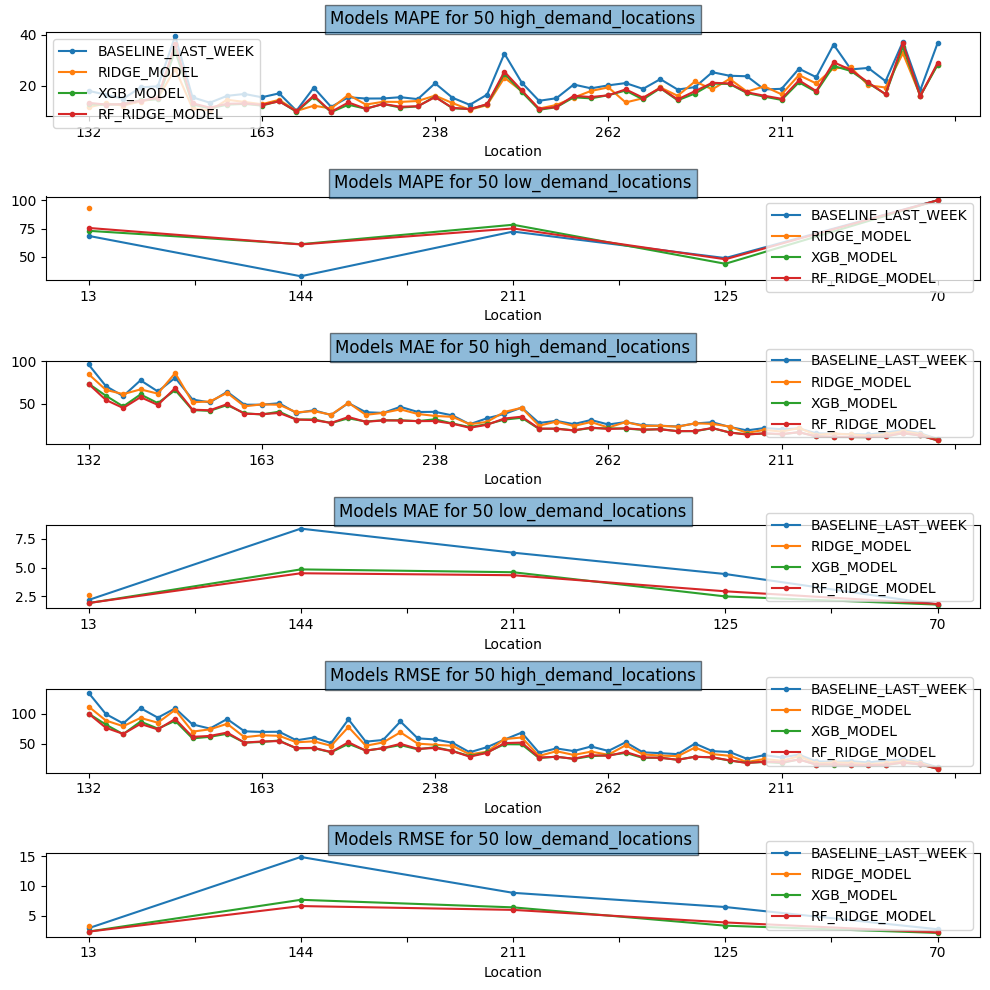

In [18]:
plot(predictions_mean_error_dict, 'Location')

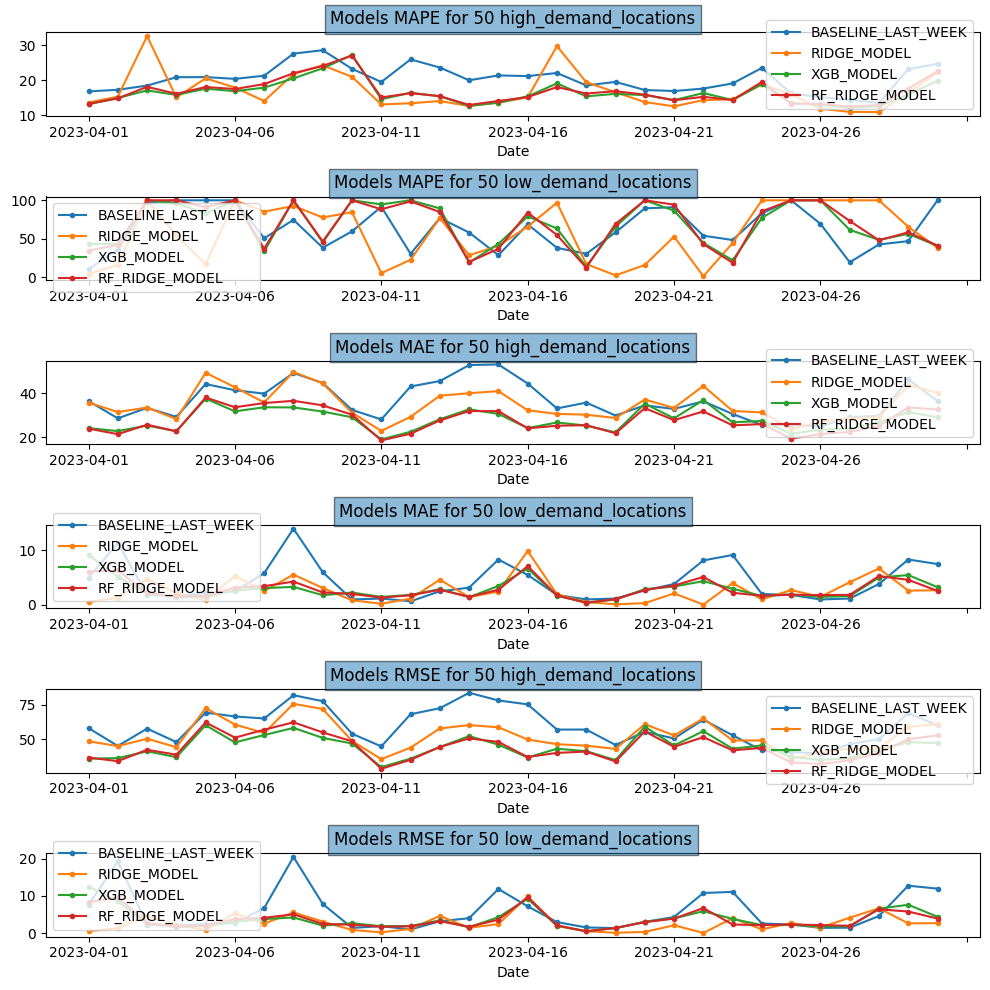

In [19]:
plot(predictions_mean_error_dict, 'Date')

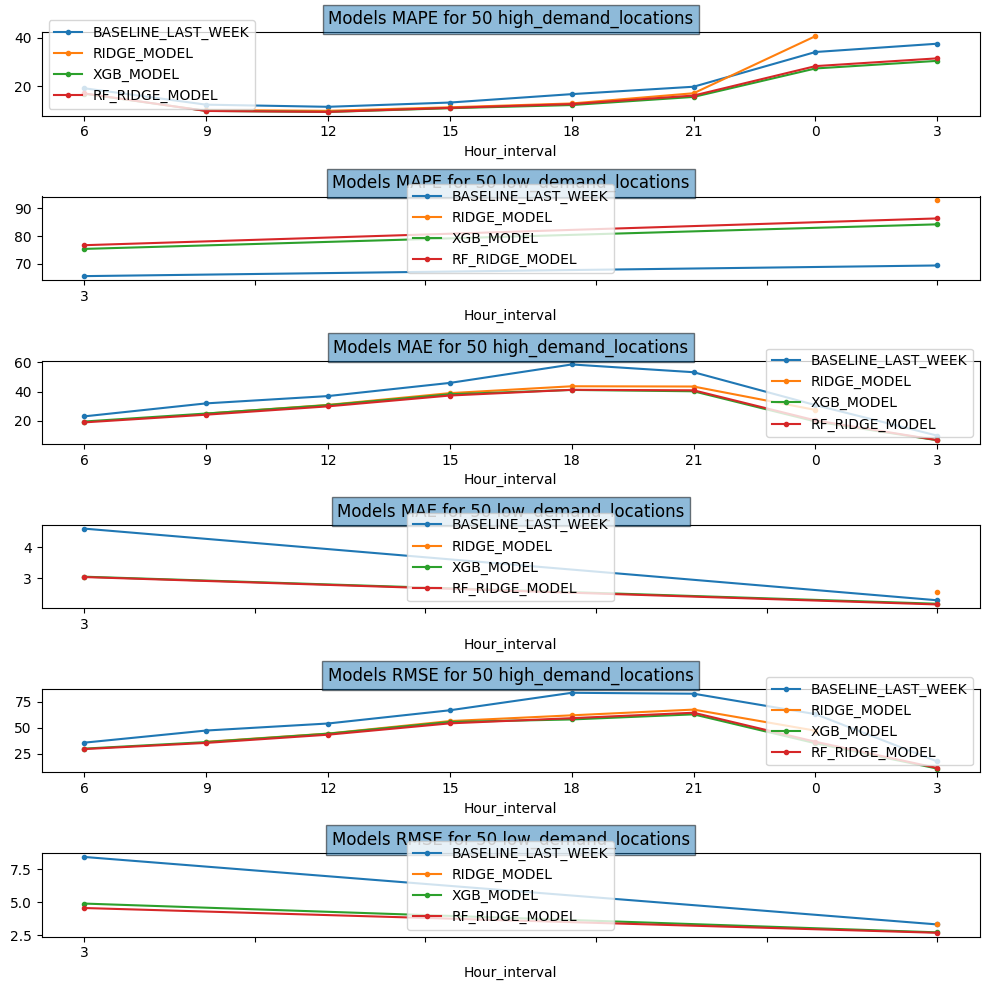

In [20]:
plot(predictions_mean_error_dict, 'Hour_interval')

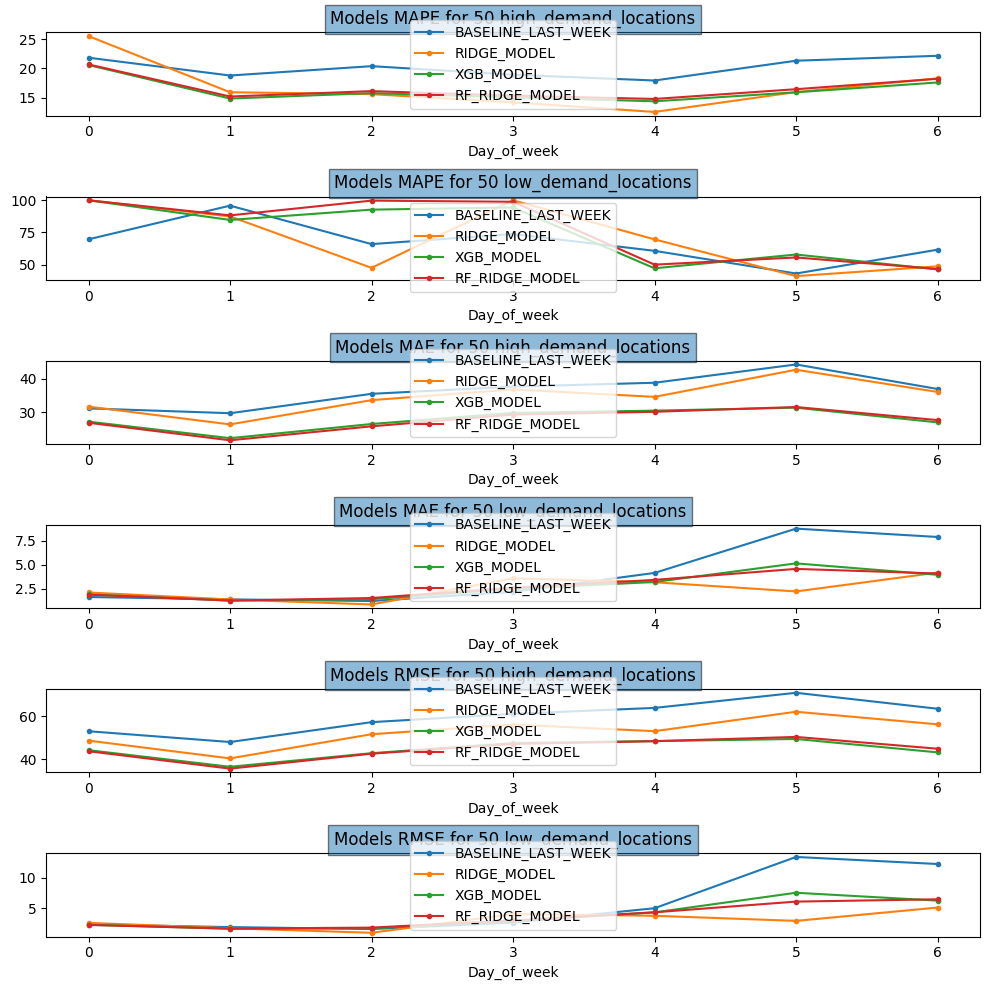

In [21]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [22]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['Location', 'Hour_interval']]
                categorized_df = error_df.merge(sorted_index, on=['Location','Hour_interval'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [23]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [24]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES, METRICS], names=['location CATEGORIES:', 'Error Metrics:']))


In [25]:
df.style.format('{:.2f}')